In [1]:
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import numpy as np
import pandas as pd
global dt
dt=(0.45E-6)**2 * (0.1666666 / (4E-6))

# Input Data from VTK
***step 1***
- ### Open the file by setting path + file name**
    - file name is cell ID (0 in our case + time step)  
- ### Read line by line
    - #### read in line 5 to get the point number of a cell 
        - in line 5: devided by `"<space>"`
            - Mark the first as point, the second as number of lines needed to read in -- `line_number_all`
    - #### keep going until meet velocity `VECTORS Velocity double` 
        - split the line by `"<space>"`
        - get the second element and identify it as velocity
        - store the following number of lines by `line_number_all`
        - *for now, get the net velocity by sum them all*
    - #### keep going until meet force `VECTORS Force double`
        - split the line by `"<space>"`
        - get the second element and identify it as force
        - store the following number of lines by `line_number_all`
        - *for now, get the net force by sum them all*

# Calculation
***step 2***  
calculate the net force, net velocity, and mass distribution from the vtk file
- ### Net Force
    - create a method in the class called net_force_calc, which returns a tuple of float (x, y, z)
    - sum up all the x, y, z from `vtk.force['x'], vtk.force['y'], vtk.force['z']` 
    - the return tuple is stored in `net_force`
- ### Net Velocity
    - create a method in the class called net_velocity_calc, which returns a tuple of float (x, y, z)
    - sum up all the x, y, z from `vtk.velocity['x'], vtk.velocity['y'], vtk.velocity['z']`  
    - the return tuple is stored in `net_velocity`
- ### Cell Center
    - create a method in the class called cell_center_calc, which returns a tuple of float (x, y, z)
    - sum up all the x, y, z from `vtk.points['x'], vtk.points['y'], vtk.points['z']`
    - the return tuple is stored in `cell_center`
- ### Mass Disribution
    - creat a method that calculate mass distribution in y direction. return a tuple of `(upper persent, lower persent)`
    - get the number of points in y direction by comparing number of the `vtk.points['y']` to the `vtk.cell_center[1]`
    - the returned tuple is stored in `mass_distribution`

In [2]:
class vtk_tag():
    def __init__(self, name, time, path, points=None, velocity=None, force=None):
        self.name = name
        self.time = time
        self.path = path
        self.points = dict() if points is None else points
        self.velocity = dict() if velocity is None else velocity
        self.force = dict() if force is None else force

    def analysis(self):
        num_points = self.points['total_points']
        # calculate net force 
        netx_f = sum(self.force['x']) / num_points
        nety_f = sum(self.force['y']) / num_points
        netz_f = sum(self.force['z']) / num_points
        self.net_force = (netx_f, nety_f, netz_f)

        # calculate net velocity
        netx_v = sum(self.velocity['x']) / num_points
        nety_v = sum(self.velocity['y']) / num_points
        netz_v = sum(self.velocity['z']) / num_points
        self.net_velocity = (netx_v, nety_v, netz_v)
    
        # calculate cell center
        netx = sum(self.points['x']) / num_points
        nety = sum(self.points['y']) / num_points
        netz = sum(self.points['z']) / num_points
        self.center = (netx, nety, netz)

        # calculate mass_distribution
        count = 0
        for points in self.points['y']:
            if points >= self.center[1]:
                count += 1
            else:
                continue
        upper_present = count / num_points 
        lower_present = 1 - upper_present
        self.mass_distribution = (upper_present, lower_present)

        

In [3]:
def float_to_str(f):
    if f == 0:
        str_out = 0
        return str_out
    else:
        if f < 0:
            sign = 'n'
        else:
            sign = ''
    f = abs(f)
    temp_float = f%1
    int_part = int(f - temp_float)
    float_part = round(f%1, 2)
    float_part = int(float_part*100)
    float_str = str(float_part)
    str_out = sign + str(int_part) + 'p' + float_str
    return str_out

In [4]:
def gene_name(axes, stiffness, coord): 
    """ 
    this function helps generate name from given cell parameters, it will take 
    axes(a float), stiffness( a float), and coord(tuble of x, y, and z), and make it a
    string to help locate the address of the folder contains cell information.  
    
    input:
        axes(float)
        stiffness(float)
        coord (tuple/list): (x, y, z)

    output:
        name(str): axes_stiffness_x_y_z use 'p' for dot and 'n' for negative
    """
    axes_str = float_to_str(axes)
    if axes_str[-1] == '0' and len(axes_str) == 4:
        axes_str = axes_str[:-1]
    stif_str = str(stiffness)
    if coord != None:
        x = float_to_str(coord[0])
        y = float_to_str(coord[1])
        z = float_to_str(coord[2])
        name = "a{}_s{}_{}_{}_{}".format(axes_str, stif_str, x, y, z)
    else:
        name = "a{}_s{}".format(axes_str, stif_str)
    return name

In [5]:
def det_axis(axis):
    if axis[0] == 'x':
        x_axis = 0
    elif axis[0] == 'y':
        x_axis = 1
    elif axis[0] == 'z':
        x_axis = 2
    
    if axis[1] == 'x':
        y_axis = 0
    elif axis[1] == 'y':
        y_axis = 1
    elif axis[1] == 'z':
        y_axis = 2
    return(x_axis, y_axis)

In [6]:
# Step 1 create object with filename stored in
# name the path by "size_stiffness"
# name will be used to find the folder for all files (time)

def gene_vtk (path, name, cell_id, timestep):
    name = name
    path = path + "/vis_" + name + ".iter/"
    filename = path + str(cell_id) + "." + str(timestep * 5000) + ".vtk"
    time = timestep
    vtk = vtk_tag(name=name, time= time, path= filename)
    return vtk

In [7]:
def read_vtk (path, name, cell_id, timestep):
    vtk = gene_vtk(path, name, cell_id, timestep)
    vtk_file = open(vtk.path, 'r')
    count = 0 # gives the number of line reading

    # initialize the range to read to be a big number
    # the number will be changed if the line has been read
    start_v = 1000000
    end_v = 1000000
    start_f = 1000000
    end_f = 1000000
    
    # initialize vtk.points class
    vtk.points['x'] = []
    vtk.points['y'] = []
    vtk.points['z'] = []

    #initializ vtk.velocity class
    vtk.velocity['x'] = []
    vtk.velocity['y'] = []
    vtk.velocity['z'] = []

    #initializ vtk.force class
    vtk.force['x'] = []
    vtk.force['y'] = []
    vtk.force['z'] = []

    while True:
        count += 1
        # Get next line from file
        line = vtk_file.readline()

        # find the line of position:
        if count == 5:
            line_split = line.split(' ')
            total_points = int(line_split[1])
            vtk.points['total_points'] = total_points

        # store position information into vtk.point
        if count > 5 and count <= 5 + total_points:
            line_split = line.split(' ')
            position_x = float(line_split[0])
            position_y = float(line_split[1])
            position_z = float(line_split[2])
            vtk.points['x'].append(position_x)
            vtk.points['y'].append(position_y)
            vtk.points['z'].append(position_z)

        # store the velocity information:
        if line == 'VECTORS Velocity double\n':
            start_v = count
            end_v = count + total_points
        
        if count > start_v and count <= end_v:
            line_split = line.split(' ')
            velocity_x = float(line_split[0])
            velocity_y = float(line_split[1])
            velocity_z = float(line_split[2])
            vtk.velocity['x'].append(velocity_x)
            vtk.velocity['y'].append(velocity_y)
            vtk.velocity['z'].append(velocity_z)
        
        # store the force information:
        if line == 'VECTORS Force double\n':
            start_f = count
            end_f = count + total_points
        
        if count > start_f and count <= end_f:
            line_split = line.split(' ')
            force_x = float(line_split[0])
            force_y = float(line_split[1])
            force_z = float(line_split[2])
            vtk.force['x'].append(force_x)
            vtk.force['y'].append(force_y)
            vtk.force['z'].append(force_z)


        # if line is empty, end of file is reached
        if not line:
            break
    
    vtk_file.close()
    return vtk

# Plot Vector Field
***step 3***  
Store the data from `read_vtk()` into a local varible and plot it with `plt.quiver`
 - plot the vector field that locate vector (velocity and force) to points.
 - plot the net velocity of the cell. 
 - plot the average surface tension to the cell.

In [8]:
def vtk_plot(path, filename_1, filename_2, cell_id, timestep, property_to_print, axis, output_path):
    """ this function print out two vector field side by side using matlibplot.pyplot.subplot
the result of the function will contain the vector fields of velocity or force (specified in 'property_to_print')

input: 
    filename_1 / filename_2 (str): filenames of the vtk to read
    cell_id (int): cell id to read, goes with filename
    timestep (int): goes with cell name
    property_to_print (str): force or velocity, determine the result plot
    axis (tuple of str): determine which axis to print
    output_path (str): where to save the file

output:
    plot of vector field (.png)
    """
    # read in data from vtk file
    ctc_1 = read_vtk(path, filename_1, cell_id, timestep)
    ctc_1.analysis()
    ctc_2 = read_vtk(path, filename_2, cell_id, timestep)
    ctc_2.analysis()

    # determine the axis to use
    ax_for_plot = det_axis(axis)
    if property_to_print == 'force':
        u1 = ctc_1.force[axis[0]]
        v1 = ctc_1.force[axis[1]]
        u2 = ctc_2.force[axis[0]]
        v2 = ctc_2.force[axis[1]]
        c = 'k'
    elif property_to_print == 'velocity':
        u1 = np.zeros(len(ctc_1.velocity[axis[0]]))
        v1 = ctc_1.velocity[axis[1]]
        u2 = np.zeros(len(ctc_2.velocity[axis[0]]))
        v2 = ctc_2.velocity[axis[1]]
        c = 'b'
    else:
        raise ValueError('Please Input "force" or "velocity"')
    
    # plot section
    # fig = plt.figure(figsize= (10, 20))
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    ax1.quiver(ctc_1.points[axis[0]], ctc_1.points[axis[1]], u1, v1, scale_units = 'x', color=c)
    ax1.quiver(ctc_1.center[ax_for_plot[0]], ctc_1.center[ax_for_plot[1]], ctc_1.net_force[ax_for_plot[0]], ctc_1.net_force[ax_for_plot[1]], 
               color = 'r', label = 'Ave_surface_tension', scale_units = 'x')
    ax1.quiver(ctc_1.center[ax_for_plot[0]], ctc_1.center[ax_for_plot[1]], ctc_1.net_velocity[ax_for_plot[0]], ctc_1.net_velocity[ax_for_plot[1]], 
               color = 'y', label = 'Net_velocity', scale_units = 'x')
    ax1.legend(loc=2, prop={'size': 4})
    ax1.set_title("{}".format(filename_1)) # change here to make the title match with the input 
    ax1.set_xlabel('{} position'.format(axis[0]))
    ax1.set_ylabel('{} position'.format(axis[1]))

    ax2.quiver(ctc_2.points[axis[0]], ctc_2.points[axis[1]], u2, v2, scale_units = 'x', color=c)
    ax2.quiver(ctc_2.center[ax_for_plot[0]], ctc_2.center[ax_for_plot[1]], ctc_2.net_force[ax_for_plot[0]], ctc_2.net_force[ax_for_plot[1]],
               color = 'r', label = 'Ave_surface_tension', scale_units = 'x')
    ax2.quiver(ctc_2.center[ax_for_plot[0]], ctc_2.center[ax_for_plot[1]], ctc_2.net_velocity[ax_for_plot[0]], ctc_2.net_velocity[ax_for_plot[1]], 
               color = 'y', label = 'Net_velocity', scale_units = 'x')
    ax2.legend(loc=2, prop={'size': 4})
    ax2.set_title("{}".format(filename_2)) # change here to make the title match with the input 
    ax2.set_xlabel('{} position'.format(axis[0]))
    ax2.set_ylabel('{} position'.format(axis[1]))
    plt.suptitle('Timestep = {}'.format(timestep))
    # plt.savefig('{}/{}_{}_{}{}_{}_st{}.png'.format(output_path, filename_1, filename_2, axis[0], axis[1], property_to_print, timestep)
    #             , dpi = 800) # change here for output direction


In [9]:
# if __name__ == '__main__':
#     path = "./OPF_analysis/" # get the absolute path of the file
#     filename_1 = 'a2p95_s5' # input the first data
#     filename_2 = 'a2p95_s80' # input the second data 
#     cell_id = 0
#     timestep = np.arange(1, 80) # specify timestep 
#     property_to_print = ['velocity'] # select mode to plot 
#     axis = [('z', 'y')] # select axis 
#     make_path = './Image_and_plot/a2p95_s5_s80_analysis/'
#     # out_folder_name =  make_path + '{}{}_{}'.format(axis[0], axis[1], property_to_print)
#     # if os.path.isdir(out_folder_name):
#     #     pass
#     # else:
#     #     os.mkdir(out_folder_name)
#     for ax in axis:
#         for ps in property_to_print:
#             out_folder_name =  make_path + '{}{}_{}'.format(ax[0], ax[1], ps)
#             if os.path.isdir(out_folder_name) is False:
#                 os.mkdir(out_folder_name)
#             for ts in timestep:
#                 vtk_plot(path, filename_1, filename_2, cell_id, ts, ps, ax, out_folder_name)


In [10]:
def calc_center_diff(path, filename_1, filename_2, cell_id, timestep):
    ctc_1 = read_vtk(path, filename_1, cell_id, timestep)
    ctc_1.analysis()
    ctc_2 = read_vtk(path, filename_2, cell_id, timestep)
    ctc_2.analysis()
    center_dif_temp = [0, 0, 0]
    for i in [0, 1, 2]:
        center_dif_temp[i] = (ctc_1.center[i] - ctc_2.center[i])**2
    center_dif = math.sqrt(sum(center_dif_temp))
    return center_dif

if __name__ == "__main__":
    center_dif = []
    path = os.path.abspath("./run/") # get the absolute path of the file
    filename_1 = 'a2p8_s10' # input the first data
    filename_2 = 'a2p9_s10' # input the second data 
    cell_id = 0
    timestep = np.arange(34, 36) + 1 # specify timestep 
    for ts in timestep:
        dist = calc_center_diff(path, filename_1, filename_2, cell_id, ts)
        center_dif.append(dist)
        print(center_dif)
    # plt.figure()
    # plt.plot(timestep, center_dif[], 'k')
    # plt.title('Distance between centers')
    # plt.xlabel('timestep')
    # plt.ylabel('distance (µm)')
    # plt.show()

# Find the velocity from a specific point
***step 4.1***  
Figure out the velocity of the specific point (time point or X axis)
 - ### Read the vtk
    - use `read_vtk` function to readin the data on a signle file.
    - store the data into a local varible to fix the number
 - ### Data Selection
    - Select the data point that is most close to bifucation point
    - Print out net_velocity, combined with the cell_center point.
 - ### Plot Data
    - x-axis to be x position and y to be velocity
    - represent different cells with colors

In [11]:
def velocity_over_x(path, cell_id, timestep, filename, output_list = None):
        output_list = [[], [], [], [], []] if output_list is None else output_list
        ctc = read_vtk(path, filename, cell_id, timestep)
        ctc.analysis()
        output_list[0].append(timestep)
        output_list[1].append(ctc.center[0])
        mag_velocity = math.sqrt(ctc.net_velocity[0]**2 + ctc.net_velocity[1]**2 + ctc.net_velocity[2]**2)
        output_list[2].append(mag_velocity)
        output_list[3].append(ctc.net_velocity[0])
        output_list[4].append(-ctc.net_velocity[1])
        return output_list

In [12]:
# # plot velocity
# path = os.path.abspath("./run/") # get the absolute path of the file
# color_list=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
# filename_list1 = ['a2p5_s5', 'a2p5_s10', 'a2p5_s20', 'a2p5_s40', 'a2p5_s80']
# filename_list2 = ['a2p75_s5', 'a2p75_s10', 'a2p75_s20', 'a2p75_s40', 'a2p75_s80']
# filename_list3 = ['a3p0_s5', 'a3p0_s10', 'a3p0_s20', 'a3p0_s40', 'a3p0_s80']
# filename_list4 = ['a3p5_s5', 'a3p5_s10', 'a3p5_s20', 'a3p5_s40', 'a3p5_s80']
# filename_list5 = ['a4p0_s5', 'a4p0_s10', 'a4p0_s20', 'a4p0_s40', 'a4p0_s80']
# # filename_list6 = ['a4p5_s5', 'a4p5_s10', 'a4p5_s20', 'a4p5_s40', 'a4p5_s80']
# file_list_list = [filename_list1, filename_list2, filename_list3, filename_list4, filename_list5]
# cell_id = 0
# timestep1 = np.arange(0, 10) + 1 # specify timestep 
# timestep2 = np.arange(25, 35) + 1
# timestep3 = np.arange(45, 55) + 1
# timestep4 = np.arange(30, 100) + 1
# timestep_list = [timestep4]
# xx = 0
# namelist = ['velocity_bp2']
# for timestep in timestep_list:
#     x_to_plot = []
#     y_to_plot = []
#     for filename_list in file_list_list:
#         for file in filename_list:
#             for i, ts in enumerate(timestep):
#                 if i == 0:
#                     output_list = velocity_over_x(path, cell_id, ts, file) # output[0] is timestep, output[1] is x position, output[2] is magnitude of net velocity
#                 else:
#                     output_list = velocity_over_x(path, cell_id, ts, file,  output_list)
#             plt.plot(output_list[1], output_list[2], '--',color=color_list[xx], label='{}'.format(file))
#         xx += 1
#     print("xx:{}, file{}".format(xx, file))
#     plt.xlabel('x position(µm)')
#     plt.ylabel('velocity (µm/ms)')
#     plt.title('V vs X at ts {} to {}'.format(timestep[0], timestep[-1]))
#     plt.ylim([0.0, 0.02])
#     plt.xlim([-140, -133])
#     plt.legend(loc=2, prop={'size': 3})
#     # plt.savefig("./all_cell_s10/{}.png".format(namelist[0]), dpi=800)
#     plt.show()
    

In [13]:
# # Try to see if I can get the plot extended to 3d, with x position to be x-axis, velocity to be z axis and cell size to be y-axis
# from mpl_toolkits.mplot3d import axes3d
# ax = plt.axes(projection='3d')
# path = os.path.abspath("./run/") # get the absolute path of the file
# color_list=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
# filename_list1 = ['a2p5_s5', 'a2p5_s10', 'a2p5_s20', 'a2p5_s40', 'a2p5_s80']
# filename_list2 = ['a2p75_s5', 'a2p75_s10', 'a2p75_s20', 'a2p75_s40', 'a2p75_s80']
# filename_list3 = ['a3p0_s5', 'a3p0_s10', 'a3p0_s20', 'a3p0_s40', 'a3p0_s80']
# filename_list4 = ['a3p5_s5', 'a3p5_s10', 'a3p5_s20', 'a3p5_s40', 'a3p5_s80']
# filename_list5 = ['a4p0_s5', 'a4p0_s10', 'a4p0_s20', 'a4p0_s40', 'a4p0_s80']
# # filename_list6 = ['a4p5_s5', 'a4p5_s10', 'a4p5_s20', 'a4p5_s40', 'a4p5_s80']
# file_list_list = [filename_list1, filename_list2, filename_list3, filename_list4, filename_list5]
# cell_id = 0
# timestep4 = np.arange(30, 100) + 1
# xx = 0
# namelist = 'velocity_bp2'
# for filename_list in file_list_list:
#     for file in filename_list:
#         for i, ts in enumerate(timestep):
#             if i == 0:
#                 output_list = velocity_over_x(path, cell_id, ts, file) # output[0] is timestep, output[1] is x position, output[2] is magnitude of net velocity
#             else:
#                 output_list = velocity_over_x(path, cell_id, ts, file,  output_list)
#         x = np.array(output_list[1])
#         y = np.ones(len(output_list[1])) * xx
#         ax.plot3D(x, y, output_list[2],color=color_list[xx], label='{}'.format(file))
#     xx += 1
# print("xx:{}, file{}".format(xx, file))
# ax.set_xlabel('x position(µm)')
# ax.set_ylabel('cell sizes')
# ax.set_zlabel('velocity (µm/ms)')
# ax.set_zlim(0.0, 0.02)
# plt.xlim([-140, -131])
# plt.legend(loc=2, prop={'size': 3})
# # ax.view_init(15, 60)
# plt.savefig("./temp_3D_velocity.png", dpi=800)
# plt.show()

# Plot The Histogram on a Single Timepoint.
***step 4.2***
At a single time point, draw a histogram about distribution of particles, force, velocities at y dimention.
- ### Read the vtk
    - use `read_vtk` function to readin the data on a signle file.
    - store the data into a local varible to fix the number  
- ### Plot Section
- use matplotlib.pyplot on:
    - plot the number of points in a single y position vs y position
    - plot force over y position
    - plot velocity over y position
    - add average number to the histogram
    - add median to the histogram

/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

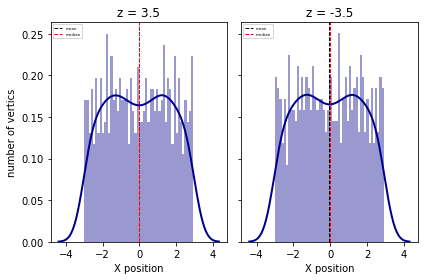

/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

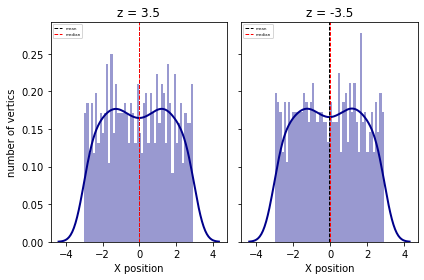

/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

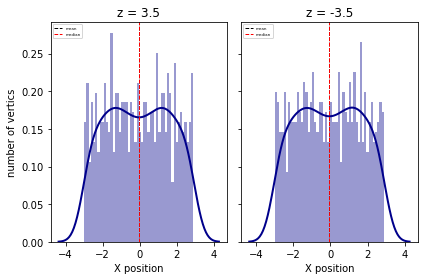

/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

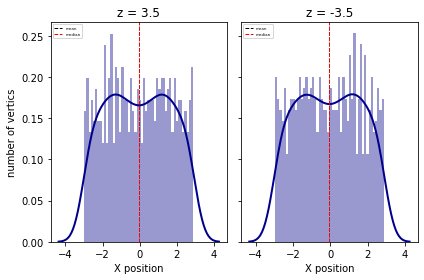

/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

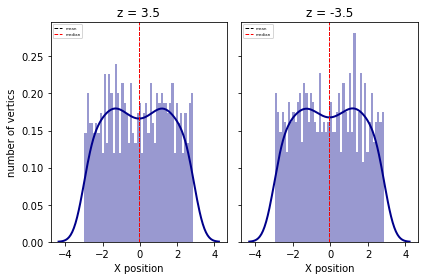

/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

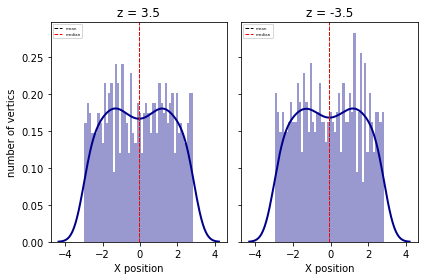

/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

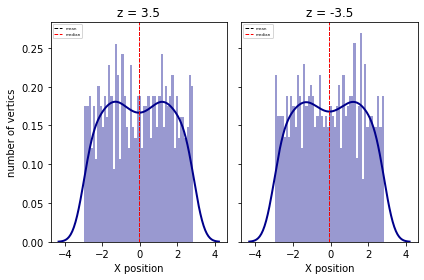

/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

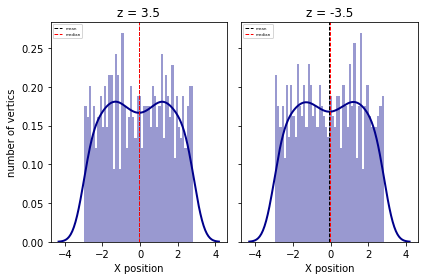

/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

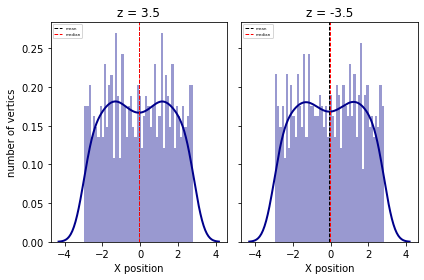

/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

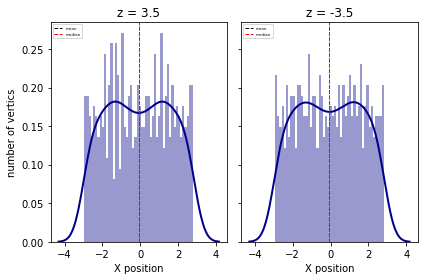

/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/junyunan/opt/anaconda3/envs/Math/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

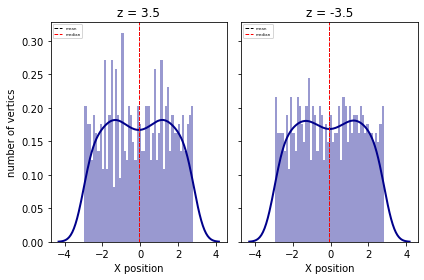

In [16]:
path = "./OPF_analysis/"
for ts in np.arange(60, 71):
    name_1 = gene_name(2.95, 40, (-230, 0, 3.5))
    ctc_80 = read_vtk(path, name_1, 0, ts)
    ctc80_points = ctc_80.points['y']
    ctc80_force = ctc_80.force['y']
    ctc80_velocity = ctc_80.velocity['y']

    name_2 = gene_name(2.95, 40, (-230, 0, -3.5))
    ctc_90 = read_vtk(path, name_2, 0, ts)
    ctc90_points = ctc_90.points['y']
    ctc90_force = ctc_90.force['y']
    ctc90_velocity = ctc_90.velocity['y']

    y1 = ctc_80.points['z']
    y2 = ctc_90.points['z']

    # xlim = (-25, -10)
    c = 'darkblue'

    plt.figure()
    fig, ax = plt.subplots(1, 2, sharey=True, tight_layout=True)
    sns.distplot(y1, ax = ax[0], 
                 hist=True, kde=True, 
                 bins=50, color = c, 
                 kde_kws={'linewidth': 2}
                )
    ax[0].axvline(np.mean(y1), color='k', linestyle='dashed', linewidth=1, label='mean')
    ax[0].axvline(np.median(y1), color='r', linestyle='dashed', linewidth=1, label='median')
    ax[0].legend(loc=2, prop={'size': 4})
    # ax[0].set_xlim(xlim)
    ax[0].set_title("z = 3.5")
    ax[0].set_xlabel('X position')
    ax[0].set_ylabel('number of vertics')

    sns.distplot(y2, ax = ax[1], 
                hist=True, kde=True, 
                bins=50, color = c, 
                kde_kws={'linewidth': 2}
            )
    ax[1].axvline(np.mean(y2), color='k', linestyle='dashed', linewidth=1,label='mean')
    ax[1].axvline(np.median(y2), color='r', linestyle='dashed', linewidth=1, label='median')
    ax[1].legend(loc=2, prop={'size': 4})
    # ax[1].set_xlim(xlim)
    ax[1].set_title("z = -3.5")
    ax[1].set_xlabel('X position')
    ax[1].set_ylabel('number of vertics')
    # plt.savefig('/Users/junyunan/Desktop/amanda lab/simulation_result_a3~7_s5_80/Image and plot/80_90_s10_analysis/Histogram/Position/Position_hist_ts{}.png'.format(ts), dpi = 800)
    plt.show()

def data_for_hist(points):
    max_position = max(points)
    min_position = min(points)
    interval = (max_position - min_position) / 20
    hist_data = {'y': [], 'count': []}
    for i in range(0, 20):
        x_point = min_position + interval * i
        x_range = (x_point, x_point + interval)
        count = 0
        for pt in points:
            if pt >= x_range[0] and pt < x_range[1]:
                count += 1
        hist_data['y'].append(x_point)
        hist_data['count'].append(count)
    hist_data['ave'] = round(statistics.mean(points), 2)
    hist_data['med'] =  round(statistics.median(points), 2)
    return hist_data

In [ ]:
dist1